# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
!pip install bigartm10

     |████████████████████████████████| 2.0MB 2.9MB/s 


In [0]:
import artm

In [0]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [0]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path='/content/drive/My Drive/lectures.txt', data_format='vowpal_wabbit',
                                        target_folder='lectures_batches', batch_size=250)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [0]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2, class_ids={'text':1, 'author':1},
                  reuse_theta=True, cache_theta=True)


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [0]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dict')
dictionary.gather(batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)


##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [0]:
# Ваш код
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod1', class_id='text', num_tokens=15))
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod2', class_id='author', num_tokens=15))


##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [0]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [0]:
# Ваш код
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [0]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                       topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [0]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [92]:
# Ваш код
tokens = model.score_tracker['top_tokens_score_mod1'].last_tokens
for topic_name in model.topic_names:
    print(topic_name + ': ', end=" ")
    for word in tokens[topic_name]:    
        print(word, end=" ")
    print()

sbj0:  власть средневековый император русь церковь александр римский святой сага папа король князь престол двор рим 
sbj1:  звезда планета земля атмосфера диск солнце белый карлик солнечный вокруг образовываться поверхность спутник газ масса 
sbj2:  система состояние трудность частота поведение создавать искусственный направление движение двигаться точность переход отрицательный цикл час 
sbj3:  культура понятие восприятие культурный рассказывать феномен сознание кандидат опыт личность ощущение лицо воспринимать каков признак 
sbj4:  право вещь должник собственность римский обязательство владение правовой собственник программный критерий имущество юрист землетрясение кредитор 
sbj5:  материал свойство свет полимер молекула углеродный электроника технология электронный полимерный бор применение одиночный использовать оптический 
sbj6:  книга фильм женщина литература автор текст написать тема кино герой кинематограф жанр анекдот культовый академия 
sbj7:  смерть литературный ритуал прави

In [93]:
# Ваш код
tokens = model.score_tracker['top_tokens_score_mod2'].last_tokens
for topic_name in model.topic_names:
    print(topic_name + ': ', end=" ")
    for word in tokens[topic_name]:    
        print(word, end=" ")
    print()

sbj0:  Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Алексей_Юдин Игорь_Данилевский Елена_Уханова Ольга_Вайнштейн Григорий_Бондаренко Владимир_Петрухин Елена_Браун Раиса_Кирсанова Екатерина_Болтунова Ольга_Тогоева Екатерина_Лямина 
sbj1:  Сергей_Попов Дмитрий_Вибе Валерий_Сулейманов Дмитрий_Титов Роман_Рафиков Александр_Потехин Наталья_Новикова Елизавета_Ривкина Зоригто_Намсараев Юлия_Краус Александр_Слободкин Александр_Марков Сергей_Наугольных Вадим_Бражкин Олег_Медведев 
sbj2:  Михаил_Пантелеев Александр_Поддьяков Владимир_Мележик Виталий_Пальчиков Антон_Суворов Михаил_Фейгельман Алексей_Желтиков Эмиль_Ахмедов Илья_Щуров Андрей_Чабовский Дмитрий_Громов Александра_Скрипченко Даниэль_Сельва Алексей_Котов Яков_Фоминов 
sbj3:  Пётр_Турчин Алексей_Руткевич Андрей_Лукашов Владимир_Миронов Максим_Кронгауз Александр_Кислов Фёдор_Гиренок Сергей_Арутюнов Павел_Степанцов Наталья_Смолянская Николай_Плотников Александр_Гофман Татьяна_Смоктунович Дмитрий_Иванов Павел_Умрюхин 
s

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [0]:
sbj_topic_labels = []   # запишите названия тем в список
for topic_name in model.topic_names[:29]:
    sbj_topic_labels.append(tokens[topic_name][0])

topic_labels = sbj_topic_labels + [u"Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [95]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model.get_theta()
print('Theta shape: %s' % str(theta.shape))
phi_a = model.get_phi(class_ids='author')
print('Phi_a shape: %s' % str(phi_a.shape))

Theta shape: (30, 2756)
Phi_a shape: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [96]:
# Ваш код
theta.iloc[:,:100]

,http://postnauka.ru/video/50406,http://postnauka.ru/video/50407,http://postnauka.ru/video/50408,http://postnauka.ru/video/50656,http://postnauka.ru/video/50659,http://postnauka.ru/video/50665,http://postnauka.ru/video/50668,http://postnauka.ru/video/50670,http://postnauka.ru/video/50699,http://postnauka.ru/video/50701,http://postnauka.ru/video/50704,http://postnauka.ru/video/50706,http://postnauka.ru/video/50786,http://postnauka.ru/video/50792,http://postnauka.ru/video/50793,http://postnauka.ru/video/50797,http://postnauka.ru/video/50798,http://postnauka.ru/video/50800,http://postnauka.ru/video/50886,http://postnauka.ru/video/51169,http://postnauka.ru/video/51171,http://postnauka.ru/video/51174,http://postnauka.ru/video/51178,http://postnauka.ru/video/51180,http://postnauka.ru/video/51184,http://postnauka.ru/video/51186,http://postnauka.ru/video/51188,http://postnauka.ru/video/51194,http://postnauka.ru/video/51196,http://postnauka.ru/video/51201,http://postnauka.ru/video/51203,http://postnauka.ru/video/51205,http://postnauka.ru/video/51288,http://postnauka.ru/video/51331,http://postnauka.ru/video/51348,http://postnauka.ru/video/51350,http://postnauka.ru/video/51353,http://postnauka.ru/video/51357,http://postnauka.ru/video/51364,http://postnauka.ru/video/51365,...,http://postnauka.ru/video/5181,http://postnauka.ru/video/5182,http://postnauka.ru/video/5184,http://postnauka.ru/video/5198,http://postnauka.ru/video/52233,http://postnauka.ru/video/52235,http://postnauka.ru/video/52238,http://postnauka.ru/video/52241,http://postnauka.ru/video/52244,http://postnauka.ru/video/52246,http://postnauka.ru/video/52256,http://postnauka.ru/video/52406,http://postnauka.ru/video/52408,http://postnauka.ru/video/52410,http://postnauka.ru/video/52412,http://postnauka.ru/video/52416,http://postnauka.ru/video/52418,http://postnauka.ru/video/52420,http://postnauka.ru/video/52422,http://postnauka.ru/video/52548,http://postnauka.ru/video/52553,http://postnauka.ru/video/52635,http://postnauka.ru/video/52637,http://postnauka.ru/video/52639,http://postnauka.ru/video/52677,http://postnauka.ru/video/52694,http://postnauka.ru/video/52738,http://postnauka.ru/video/52750,http://postnauka.ru/video/52768,http://postnauka.ru/video/52778,http://postnauka.ru/video/52861,http://postnauka.ru/video/52871,http://postnauka.ru/video/52936,http://postnauka.ru/video/52941,http://postnauka.ru/video/52948,http://postnauka.ru/video/5295,http://postnauka.ru/video/52957,http://postnauka.ru/video/52958,http://postnauka.ru/video/53044,http://postnauka.ru/video/53045
sbj0,1.601879e-03,5.777061e-03,2.091580e-14,3.823352e-03,4.480955e-03,0.000000e+00,2.867998e-01,2.317410e-03,3.148277e-15,1.152021e-08,3.117835e-04,1.941041e-08,0.000000e+00,9.492568e-08,2.158783e-03,5.071638e-11,2.269193e-02,4.246802e-03,0.000000e+00,7.006973e-04,8.578751e-06,0.000000e+00,1.349101e-03,5.817282e-04,0.000000e+00,1.626496e-03,9.883533e-03,9.446073e-14,8.461841e-16,5.235261e-03,7.552826e-08,0.000000e+00,4.019636e-09,1.724218e-04,5.654870e-05,0.000000e+00,0.000000e+00,1.828101e-02,4.655060e-15,1.033902e-11,...,1.231282e-06,3.251264e-06,0.000000e+00,0.000000e+00,2.991572e-02,0.000000e+00,6.545824e-05,2.261472e-04,1.821747e-12,8.946614e-05,0.000000e+00,1.994279e-03,2.465872e-10,0.000000e+00,4.484373e-03,1.739422e-03,4.868681e-02,4.210666e-03,8.371147e-03,0.000000e+00,0.000000e+00,2.037934e-05,0.000000e+00,1.370452e-06,1.540908e-08,1.072758e-01,0.000000e+00,1.671129e-01,3.242169e-02,2.480305e-06,1.261829e-01,1.486272e-11,2.279708e-03,2.211364e-03,1.879453e-12,0.000000e+00,3.884523e-02,1.437564e-01,0.000000e+00,3.144351e-05
sbj1,1.275197e-07,1.553010e-11,5.159102e-02,1.235118e-03,5.234813e-05,2.217519e-02,4.950658e-03,1.462626e-03,1.618915e-03,1.545887e-09,5.411749e-05,3.300300e-10,7.513137e-10,8.729979e-06,9.770016e-12,8.729977e-03,4.800623e-11,2.893296e-04,5.044114e-08,6.786746e-03,7.496949e-10,1.257238e-04,2.345788e-09,1.200303e-03,4.401535e-04,0.000000e+00,2.131475e-03,1.149798e-02,5.559683e-02,3.531273e

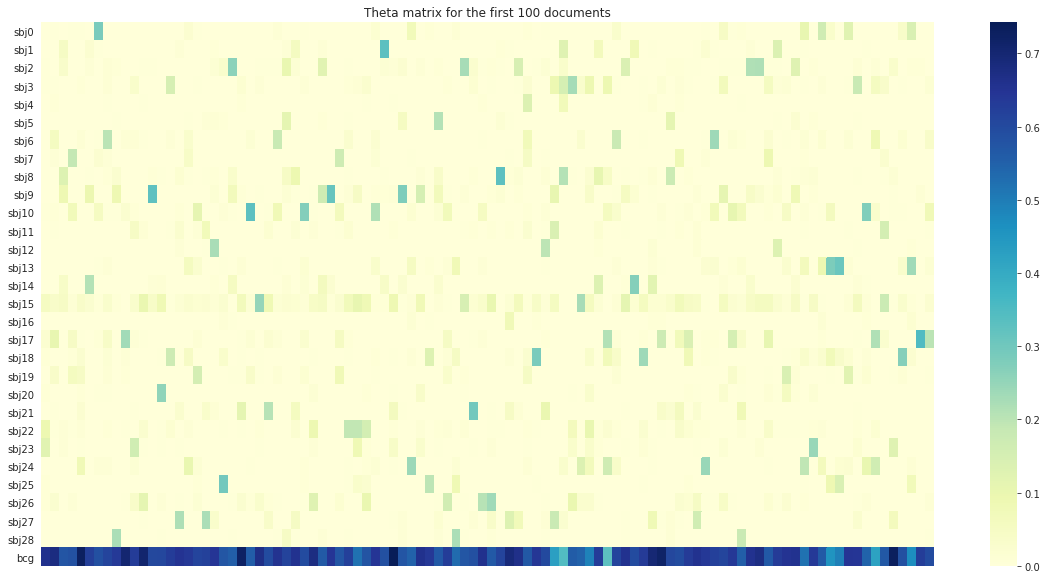

In [98]:
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
seaborn.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [99]:
prob_theme_data = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
prob_theme_data_normed = prob_theme_data / np.sum(prob_theme_data)
prob_theme = pd.DataFrame(data=prob_theme_data_normed, index=topic_labels, columns=['prob'])
prob_theme

,prob
Александр_Марей,0.013789
Сергей_Попов,0.013228
Михаил_Пантелеев,0.011750
Пётр_Турчин,0.021888
Дмитрий_Дождев,0.008478
Валентин_Крапошин,0.009443
Александр_Павлов,0.009847
Михаил_Бойцов,0.005914
Артем_Оганов,0.023196
Дмитрий_Казаков,0.025725


In [100]:
prob_theme_max = prob_theme
prob_theme_min = prob_theme

print('Max 5 probabilities:')
for i in range(5):
    max_value = prob_theme_max.max()[0]
    print(prob_theme_max[prob_theme_max.values == max_value].index[0])
    prob_theme_max = prob_theme_max[prob_theme_max.values != max_value]

print('\nMin 3 probabilities:')
for i in range(3):
    min_value = prob_theme_min.min()[0]
    print(prob_theme_min[prob_theme_min.values == min_value].index[0])
    prob_theme_min = prob_theme_min[prob_theme_min.values != min_value]

Max 5 probabilities:
Фоновая тема
Мария_Фаликман
Константин_Северинов
Дмитрий_Казаков
Артем_Оганов

Min 3 probabilities:
Станислав_Дробышевский
Михаил_Бойцов
Владимир_Пудалов


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Ваш ответ:
---


5 тем с max p(t):Фоновая тема
Мария_Фаликман
Константин_Северинов
Дмитрий_Казаков
Артем_Оганов
3 темы с min p(t):Станислав_Дробышевский
Михаил_Бойцов
Владимир_Пудалов

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

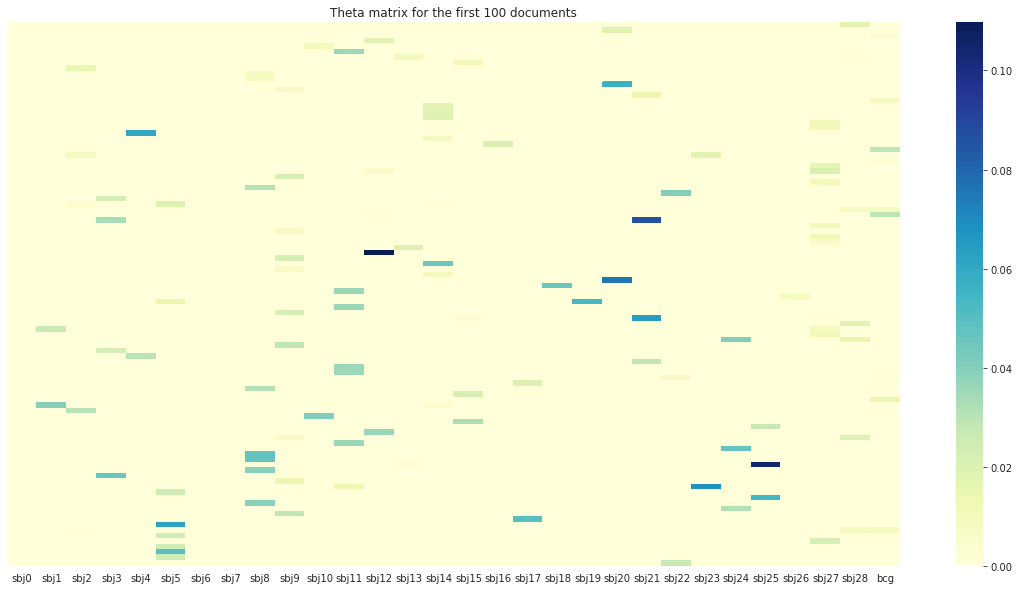

In [102]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
seaborn.heatmap(phi_a.iloc[:100], cmap='YlGnBu', yticklabels=False)
plt.show();

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [103]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,sbj10,sbj11,sbj12,sbj13,sbj14,sbj15,sbj16,sbj17,sbj18,sbj19,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Александр_Шварцбург)",0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,1.763580e-02,0.000000e+00
"(author, Сергей_Карабасов)",0.000000e+00,0.0,0.000000,0.0,0.0,1.742510e-13,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.01888,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
"(author, Ярослав_Исполатов)",0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.00000,3.684838e-13,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,3.692210e-03
"(author, Герберт_Хупперт)",0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,1.829099e-02,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,3.908967e-12,0.000000e+00
"(author, Арчил_Балахванцев)",5.342829e-12,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.010208,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(author, Иван_Луковников)",0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.021734,0.0,0.000000e+00,0.000000,0.0,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
"(author, Анатолий_Баранов)",0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0,1.334594e-16,0.068906,0.0,0.00000,0.000000e+00,1.362324e-16,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,2.545014e-10
"(author, Алла_Ножевникова)",0.000000e+00,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.046881,0.0,0.000000,0.0,4.565268e-15,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.00000,0.000000e+00,0.000000e+00,5.120492e-09,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
"(author, Виталий_Пальчиков)",0.000000e+00,0.0,0.061335,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,1.226460e-09,0.000000,0.0,0.000000e+00,0.000000,0.0,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00


In [104]:
for i in range(phi_a.shape[0]):
    num_valuble_topics = 0
    for val in phi_a.iloc[i]:
        if val > 0.01:
            num_valuble_topics += 1
    if num_valuble_topics >= 3:
        print(i),
        print(phi_a.index[i])

260
('author', 'Шринивас_Шридхар')
455
('author', 'Андрей_Цатурян')
466
('author', 'Ольга_Вайнштейн')
485
('author', 'Ольга_Тогоева')
497
('author', 'Михаил_Маяцкий')
504
('author', 'Дина_Гусейнова')
528
('author', 'Фуад_Алескеров')


In [105]:
print(phi_a.iloc[184])

sbj0     0.000000e+00
sbj1     3.774870e-08
sbj2     0.000000e+00
sbj3     0.000000e+00
sbj4     0.000000e+00
sbj5     0.000000e+00
sbj6     0.000000e+00
sbj7     0.000000e+00
sbj8     2.096046e-15
sbj9     0.000000e+00
sbj10    0.000000e+00
sbj11    0.000000e+00
sbj12    0.000000e+00
sbj13    0.000000e+00
sbj14    0.000000e+00
sbj15    0.000000e+00
sbj16    0.000000e+00
sbj17    0.000000e+00
sbj18    0.000000e+00
sbj19    0.000000e+00
sbj20    0.000000e+00
sbj21    0.000000e+00
sbj22    0.000000e+00
sbj23    7.736317e-02
sbj24    0.000000e+00
sbj25    0.000000e+00
sbj26    0.000000e+00
sbj27    0.000000e+00
sbj28    0.000000e+00
bcg      0.000000e+00
Name: (author, Владимир_Кузнецов), dtype: float32


Ваш ответ:
авторы, значимые в не менее чем 3 темах: Шринивас_Шридхар, Андрей_Цатурян,Ольга_Вайнштейн, Ольга_Тогоева, Михаил_Маяцкий, Дина_Гусейнова, Фуад_Алескеров, Владимир_Кузнецов

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [0]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [0]:
# Ваш код
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)

In [0]:
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

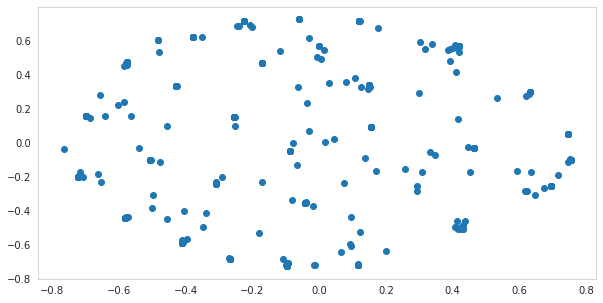

In [109]:
# Ваш код
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

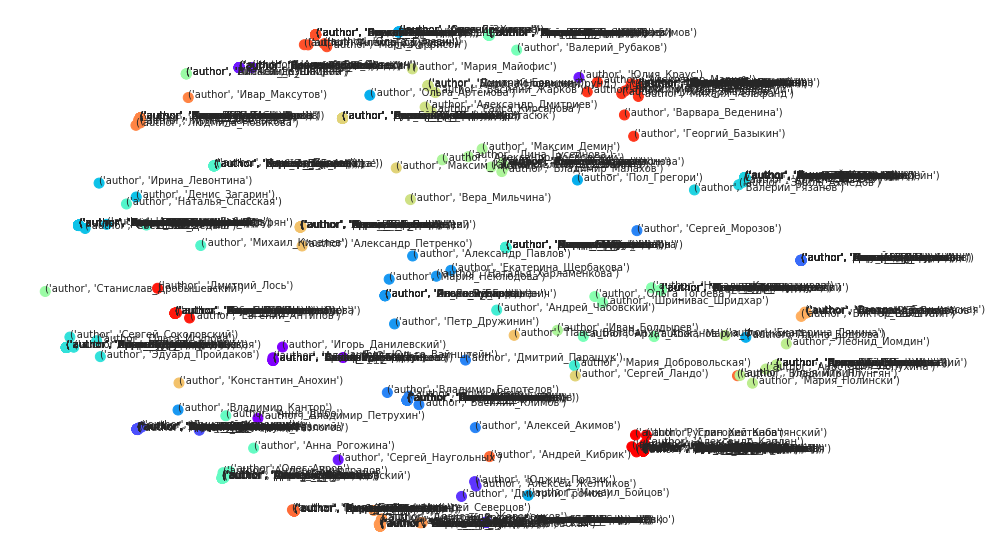

In [110]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [111]:
# Ваш код
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[1957,  157, 2592, ..., 2378, 2374, 2755],
       [ 621,  121, 1869, ..., 1642, 1643, 2755],
       [  21, 1771, 1797, ..., 2245, 2246, 2239],
       ...,
       [1676, 2476, 1303, ...,  548,  547, 2755],
       [ 548, 1744,  294, ..., 1026, 1027, 2755],
       [1078, 1728,  278, ..., 1089, 2746, 2618]])

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [113]:
print ("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [114]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [115]:
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[model.topic_names[i]][j]),
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

Александр_Марей
Фёдор_Успенский
Павел_Уваров
Татьяна_Бобровникова
Алексей_Юдин
Игорь_Данилевский
Елена_Уханова
Ольга_Вайнштейн
Григорий_Бондаренко
Владимир_Петрухин

http://postnauka.ru/video/3348
http://postnauka.ru/video/3348
http://postnauka.ru/video/9299
http://postnauka.ru/video/9299
http://postnauka.ru/video/24039
http://postnauka.ru/video/24034
http://postnauka.ru/video/9968
http://postnauka.ru/video/9968
http://postnauka.ru/video/42999
http://postnauka.ru/video/42999


Сергей_Попов
Дмитрий_Вибе
Валерий_Сулейманов
Дмитрий_Титов
Роман_Рафиков
Александр_Потехин
Наталья_Новикова
Елизавета_Ривкина
Зоригто_Намсараев
Юлия_Краус

http://postnauka.ru/video/31695
http://postnauka.ru/video/31695
http://postnauka.ru/video/53693
http://postnauka.ru/video/53693
http://postnauka.ru/video/32889
http://postnauka.ru/video/32889
http://postnauka.ru/video/36249
http://postnauka.ru/video/36249
http://postnauka.ru/video/51364
http://postnauka.ru/video/51364


Михаил_Пантелеев
Александр_Поддьяков
Владимир_Мележик
Виталий_Пальчиков
Антон_Суворов
Михаил_Фейгельман
Алексей_Желтиков
Эмиль_Ахмедов
Илья_Щуров
Андрей_Чабовский

http://postnauka.ru/video/51174
http://postnauka.ru/video/51174
http://postnauka.ru/video/51382
http://postnauka.ru/video/51382
http://postnauka.ru/video/56618
http://postnauka.ru/video/56618
http://postnauka.ru/video/3602
http://postnauka.ru/video/3602
http://postnauka.ru/video/1856
http://postnauka.ru/video/52553


Пётр_Турчин
Алексей_Руткевич
Андрей_Лукашов
Владимир_Миронов
Максим_Кронгауз
Александр_Кислов
Фёдор_Гиренок
Сергей_Арутюнов
Павел_Степанцов
Наталья_Смолянская

http://postnauka.ru/video/11034
http://postnauka.ru/video/13098
http://postnauka.ru/video/12740
http://postnauka.ru/video/5891
http://postnauka.ru/video/5891
http://postnauka.ru/video/12524
http://postnauka.ru/video/7169
http://postnauka.ru/video/7169
http://postnauka.ru/video/7747
http://postnauka.ru/video/7747


Дмитрий_Дождев
Денис_Новак
Евгений_Рогожин
Виктор_Цетлин
Марина_Бутовская
Дмитрий_Полдников
Алиса_Вячеславова
Александр_Парфенов
Мохамад_Кассаб
Дмитрий_Дорохов

http://postnauka.ru/video/38009
http://postnauka.ru/video/38009
http://postnauka.ru/video/31688
http://postnauka.ru/video/31688
http://postnauka.ru/video/17913
http://postnauka.ru/video/16822
http://postnauka.ru/video/49455
http://postnauka.ru/video/49455
http://postnauka.ru/video/34414
http://postnauka.ru/video/34414


Валентин_Крапошин
Дмитрий_Паращук
Дмитрий_Гольберг
Алексей_Хохлов
Дмитрий_Клинов
Владимир_Комлев
Эрик_Мазур
Владимир_Белотелов
Алексей_Акимов
Михаил_Эпштейн

http://postnauka.ru/video/13544
http://postnauka.ru/video/41686
http://postnauka.ru/video/41686
http://postnauka.ru/video/36655
http://postnauka.ru/video/36655
http://postnauka.ru/video/36657
http://postnauka.ru/video/36657
http://postnauka.ru/video/58542
http://postnauka.ru/video/58542
http://postnauka.ru/video/36490


Александр_Павлов
Павел_Руднев
Ян_Левченко
Мария_Неклюдова
Владимир_Кантор
Ольга_Эдельман
Алексей_Бартошевич
Петр_Дружинин
Ольга_Вайнштейн
Наталья_Харламенкова

http://postnauka.ru/video/39723
http://postnauka.ru/video/39723
http://postnauka.ru/video/10759
http://postnauka.ru/video/38510
http://postnauka.ru/video/38510
http://postnauka.ru/video/47204
http://postnauka.ru/video/47204
http://postnauka.ru/video/42807
http://postnauka.ru/video/42807
http://postnauka.ru/video/47202


Михаил_Бойцов
Анна_Соколова
Олег_Лекманов
Сергей_Зенкин
Арсений_Хитров
Ольга_Артёмова
Алина_Бодрова
Михаил_Маяцкий
Игорь_Данилевский
Пол_Грегори

http://postnauka.ru/video/1893
http://postnauka.ru/video/48480
http://postnauka.ru/video/48480
http://postnauka.ru/video/48335
http://postnauka.ru/video/48335
http://postnauka.ru/video/37992
http://postnauka.ru/video/37992
http://postnauka.ru/video/47449
http://postnauka.ru/video/47449
http://postnauka.ru/video/32882


Артем_Оганов
Валерий_Фокин
Валентин_Ненайденко
Алла_Ножевникова
Александр_Беленький
Алексей_Малашенко
Константин_Мирошников
Сергей_Майоров
Дмитрий_Бак
Сергей_Румянцев

http://postnauka.ru/video/12375
http://postnauka.ru/video/13700
http://postnauka.ru/video/8953
http://postnauka.ru/video/8953
http://postnauka.ru/video/18048
http://postnauka.ru/video/9144
http://postnauka.ru/video/9144
http://postnauka.ru/video/48107
http://postnauka.ru/video/48107
http://postnauka.ru/video/51490


Дмитрий_Казаков
Эмиль_Ахмедов
Михаил_Данилов
Игорь_Волобуев
Лев_Дудко
Алексей_Рубцов
Сергей_Троицкий
Александр_Львовский
Андрей_Семенов
Виктор_Брагута

http://postnauka.ru/video/13043
http://postnauka.ru/video/22760
http://postnauka.ru/video/18873
http://postnauka.ru/video/14283
http://postnauka.ru/video/53507
http://postnauka.ru/video/53507
http://postnauka.ru/video/47952
http://postnauka.ru/video/47952
http://postnauka.ru/video/47950
http://postnauka.ru/video/47950


Илья_Женин
Борис_Морозов
Кирилл_Соловьев
Кирилл_Кочегаров
Александр_Лаврентьев
Олег_Будницкий
Александр_Каменский
Ирина_Бёме
Евгений_Магид
Илья_Виньковецкий

http://postnauka.ru/video/46939
http://postnauka.ru/video/46939
http://postnauka.ru/video/31183
http://postnauka.ru/video/19574
http://postnauka.ru/video/35041
http://postnauka.ru/video/35041
http://postnauka.ru/video/41895
http://postnauka.ru/video/41895
http://postnauka.ru/video/25906
http://postnauka.ru/video/29992


Катерина_Поливанова
Ольга_Сварник
Леонид_Марголис
Андрей_Чабовский
Мария_Падун
Ольга_Исупова
Максим_Киселев
Дэвид_С._Джонс
Мария_Медникова
Джеральд_де_Хаан

http://postnauka.ru/video/59638
http://postnauka.ru/video/59638
http://postnauka.ru/video/22892
http://postnauka.ru/video/60527
http://postnauka.ru/video/60527
http://postnauka.ru/video/40266
http://postnauka.ru/video/40266
http://postnauka.ru/video/57866
http://postnauka.ru/video/57866
http://postnauka.ru/video/30678


Егор_Задереев
Михаил_Бурцев
Виктория_Битюкова
Виктор_Зайченко
Михаил_Киселев
Алишер_Тураев
Андрей_Цатурян
Константин_Агладзе
Сергей_Писарев
Филипп_Хайтович

http://postnauka.ru/video/46562
http://postnauka.ru/video/46562
http://postnauka.ru/video/33793
http://postnauka.ru/video/33793
http://postnauka.ru/video/23776
http://postnauka.ru/video/51169
http://postnauka.ru/video/51169
http://postnauka.ru/video/35065
http://postnauka.ru/video/35065
http://postnauka.ru/video/23172


Алексей_Муравьёв
Дмитрий_Беляев
Марк_Ульянов
Дмитрий_Худяков
Андрей_Виноградов
Нина_Сумбатова
Сергей_Серёгичев
Ольга_Брилева
Анна_Дыбо
Олег_Ауров

http://postnauka.ru/video/53171
http://postnauka.ru/video/53171
http://postnauka.ru/video/59201
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/50071
http://postnauka.ru/video/50071
http://postnauka.ru/video/10751
http://postnauka.ru/video/3387
http://postnauka.ru/video/3387


Алексей_Расторгуев
Ольга_Сильченко
Анатолий_Засов
Олег_Верходанов
Владимир_Сурдин
Андрей_Иванцов
Алексей_Старобинский
Дмитрий_Горбунов
Михаил_Ревнивцев
Сергей_Блинников

http://postnauka.ru/video/7067
http://postnauka.ru/video/7067
http://postnauka.ru/video/6673
http://postnauka.ru/video/6673
http://postnauka.ru/video/2971
http://postnauka.ru/video/57338
http://postnauka.ru/video/57338
http://postnauka.ru/video/30015
http://postnauka.ru/video/35072
http://postnauka.ru/video/35072


Мария_Фаликман
Игорь_Уточкин
Владимир_Спиридонов
Наталья_Кисельникова
Ксения_Паниди
Антон_Чижов
Александр_Тормасов
Сет_Ллойд
Станислав_Клименко
Махзарин_Банаджи

http://postnauka.ru/video/24451
http://postnauka.ru/video/24182
http://postnauka.ru/video/46933
http://postnauka.ru/video/46933
http://postnauka.ru/video/58752
http://postnauka.ru/video/58752
http://postnauka.ru/video/50349
http://postnauka.ru/video/50349
http://postnauka.ru/video/55327
http://postnauka.ru/video/55327


Станислав_Дробышевский
Виталий_Кушниров
Александр_Шацкий
Владимир_Муронец
Митчел_Резник
Леонид_Иомдин
Раиса_Кирсанова
Андрей_Летаров
Александра_Архипова
Александр_Воеводский

http://postnauka.ru/video/31707
http://postnauka.ru/video/31707
http://postnauka.ru/video/32898
http://postnauka.ru/video/32898
http://postnauka.ru/video/42707
http://postnauka.ru/video/42707
http://postnauka.ru/video/40880
http://postnauka.ru/video/40880
http://postnauka.ru/video/31675
http://postnauka.ru/video/31675


Алексей_Козырев
Кирилл_Титаев
Елена_Брызгалина
Иван_Болдырев
Владимир_Малахов
Дина_Гусейнова
Александр_Павлов
Петр_Резвых
Валентина_Харитонова
Дмитрий_Балалыкин

http://postnauka.ru/video/12738
http://postnauka.ru/video/32906
http://postnauka.ru/video/32906
http://postnauka.ru/video/3418
http://postnauka.ru/video/3418
http://postnauka.ru/video/53044
http://postnauka.ru/video/53044
http://postnauka.ru/video/37965
http://postnauka.ru/video/37965
http://postnauka.ru/video/2526


Александр_Пиперски
Владимир_Плунгян
Анатолий_Баранов
Петр_Аркадьев
Надежда_Онипенко
Дмитрий_Добровольский
Светлана_Евграфова
Борис_Иомдин
Андрей_Кибрик
Екатерина_Лютикова

http://postnauka.ru/video/36272
http://postnauka.ru/video/36272
http://postnauka.ru/video/56616
http://postnauka.ru/video/56616
http://postnauka.ru/video/48960
http://postnauka.ru/video/48960
http://postnauka.ru/video/47548
http://postnauka.ru/video/47548
http://postnauka.ru/video/1898
http://postnauka.ru/video/6720


Дмитрий_Бовыкин
Борис_Колоницкий
Василий_Жарков
Раиса_Кирсанова
Вера_Мильчина
Александр_Дмитриев
Алексей_Миллер
Дина_Гусейнова
Марина_Новикова-Грунд
Мария_Майофис

http://postnauka.ru/video/48492
http://postnauka.ru/video/48492
http://postnauka.ru/video/47823
http://postnauka.ru/video/47823
http://postnauka.ru/video/43843
http://postnauka.ru/video/43843
http://postnauka.ru/video/5396
http://postnauka.ru/video/5396
http://postnauka.ru/video/45548
http://postnauka.ru/video/45548


Максим_Франк-Каменецкий
Екатерина_Лапина-Кратасюк
Оксана_Запорожец
Руслан_Смелянский
Александр_Сафонов
Алексей_Лебедев
Екатерина_Ларионова
Ольга_Артёмова
Деметрис_Зейналипур
Джанмарко_Веруджио

http://postnauka.ru/video/13742
http://postnauka.ru/video/12515
http://postnauka.ru/video/11634
http://postnauka.ru/video/47301
http://postnauka.ru/video/47301
http://postnauka.ru/video/9998
http://postnauka.ru/video/9998
http://postnauka.ru/video/7068
http://postnauka.ru/video/7068
http://postnauka.ru/video/50792


Алексей_Алексеев
Константин_Анохин
Вера_Ижевская
Александр_Васильев
Алексей_Чжао
Ярослав_Ашихмин
Павел_Балабан
Олег_Медведев
Александр_Петренко
Юрий_Вайнер

http://postnauka.ru/video/54325
http://postnauka.ru/video/54325
http://postnauka.ru/video/2541
http://postnauka.ru/video/13746
http://postnauka.ru/video/55539
http://postnauka.ru/video/55539
http://postnauka.ru/video/51384
http://postnauka.ru/video/51384
http://postnauka.ru/video/532
http://postnauka.ru/video/532


Виктор_Вахштайн
Дмитрий_Ветров
Александр_Дьяконов
Светлана_Баньковская
Сезар_Идальго
Леонид_Иомдин
Джозеф_Браун
Владик_Аветисов
Дэвид_Вайнберг
Шринивас_Шридхар

http://postnauka.ru/video/12083
http://postnauka.ru/video/3628
http://postnauka.ru/video/3628
http://postnauka.ru/video/10783
http://postnauka.ru/video/434
http://postnauka.ru/video/434
http://postnauka.ru/video/11640
http://postnauka.ru/video/17491
http://postnauka.ru/video/32901
http://postnauka.ru/video/32901


Елизавета_Бонч-Осмоловская
Александр_Жданов
Владимир_Кузнецов
Илья_Щуров
Дмитрий_Рогозин
Александр_Жаворонков
Николай_Пименов
Максим_Таланов
Иван_Оселедец
Станислав_Протасов

http://postnauka.ru/video/2531
http://postnauka.ru/video/9389
http://postnauka.ru/video/9389
http://postnauka.ru/video/52738
http://postnauka.ru/video/52738
http://postnauka.ru/video/31671
http://postnauka.ru/video/31671
http://postnauka.ru/video/2947
http://postnauka.ru/video/37976
http://postnauka.ru/video/37976


Гасан_Гусейнов
Олег_Воскобойников
Владимир_Емельянов
Мария_Штейнман
Иван_Ладынин
Галина_Зеленина
Аскольд_Иванчик
Леонид_Григорьев
Ирина_Савельева
Владимир_Бобровников

http://postnauka.ru/video/10779
http://postnauka.ru/video/12527
http://postnauka.ru/video/9556
http://postnauka.ru/video/9556
http://postnauka.ru/video/43664
http://postnauka.ru/video/43664
http://postnauka.ru/video/21631
http://postnauka.ru/video/5394
http://postnauka.ru/video/5394
http://postnauka.ru/video/9997


Игорь_Исаев
Кирилл_Бабаев
Владимир_Плунгян
Георгий_Старостин
Григорий_Крейдлин
Андрей_Кибрик
Евгений_Зуев
Светлана_Бурлак
Илья_Иткин
Владимир_Беликов

http://postnauka.ru/video/8964
http://postnauka.ru/video/8964
http://postnauka.ru/video/13041
http://postnauka.ru/video/48114
http://postnauka.ru/video/48114
http://postnauka.ru/video/10773
http://postnauka.ru/video/4280
http://postnauka.ru/video/4280
http://postnauka.ru/video/7525
http://postnauka.ru/video/7525


Олег_Хлевнюк
Алексей_Белянин
Фуад_Алескеров
Ольга_Малинова
Филипп_Хайтович
Александр_Аузан
Сергей_Гуриев
Виктор_Полтерович
Сергей_Пекарский
Ольга_Гулевич

http://postnauka.ru/video/31684
http://postnauka.ru/video/31684
http://postnauka.ru/video/6497
http://postnauka.ru/video/6497
http://postnauka.ru/video/7781
http://postnauka.ru/video/7781
http://postnauka.ru/video/9389
http://postnauka.ru/video/9389
http://postnauka.ru/video/56290
http://postnauka.ru/video/56290


Константин_Северинов
Евгений_Шеваль
Михаил_Гельфанд
Сергей_Киселев
Максим_Франк-Каменецкий
Антон_Буздин
Петр_Федичев
Георгий_Базыкин
Инга_Полетаева
Константин_Лукьянов

http://postnauka.ru/video/5915
http://postnauka.ru/video/5915
http://postnauka.ru/video/19436
http://postnauka.ru/video/5390
http://postnauka.ru/video/5390
http://postnauka.ru/video/10475
http://postnauka.ru/video/32881
http://postnauka.ru/video/32881
http://postnauka.ru/video/17051
http://postnauka.ru/video/10754


Владимир_Пудалов
Елена_Вишленкова
Дмитрий_Лось
Наталья_Ростиславлева
Юрий_Яшков
Илья_Шкредов
Анна_Дыбо
Михаил_Киселев
Евгений_Антипов
Алексей_Орлов

http://postnauka.ru/video/2973
http://postnauka.ru/video/50340
http://postnauka.ru/video/50340
http://postnauka.ru/video/50699
http://postnauka.ru/video/50699
http://postnauka.ru/video/51380
http://postnauka.ru/video/51380
http://postnauka.ru/video/31198
http://postnauka.ru/video/55756
http://postnauka.ru/video/55756


Михаил_Соколов
Сергей_Неклюдов
Кирилл_Мартынов
Виталий_Куренной
Михаил_Алексеевский
Александр_Филиппов
Алексей_Маслов
ПостНаука
Кирилл_Еськов
Фуад_Алескеров

http://postnauka.ru/video/12376
http://postnauka.ru/video/49851
http://postnauka.ru/video/49851
http://postnauka.ru/video/30625
http://postnauka.ru/video/14293
http://postnauka.ru/video/5602
http://postnauka.ru/video/5602
http://postnauka.ru/video/48452
http://postnauka.ru/video/48452
http://postnauka.ru/video/51365


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 